In [1]:
import json
from collections import defaultdict
from functools import reduce
from matplotlib import pyplot as plt
import numpy as np
import cv2
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from tqdm import tqdm
import os
import copy
import shutil
from os import listdir
from os.path import isfile, join
# from ipynb.fs.full... import 

In [2]:
data = json.load(open('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/new_test_generali_17_05_2022.json'))
print(len(data['images']))
print(len(data['annotations']))
print(data['categories'], end='\n\n')
print(data['annotations'][0], end='\n\n')
print(data['images'][0], end='\n\n')

4474
12467
[{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}, {'supercategory': 'Carparts', 'id': 1, 'name': 'dent'}, {'supercategory': 'Carparts', 'id': 2, 'name': 'crack'}, {'supercategory': 'Carparts', 'id': 3, 'name': 'broken'}, {'supercategory': 'Carparts', 'id': 4, 'name': 'lamp_broken'}, {'supercategory': 'Carparts', 'id': 5, 'name': 'glass_broken'}, {'supercategory': 'Carparts', 'id': 6, 'name': 'hole'}, {'supercategory': 'Carparts', 'id': 7, 'name': 'totaled'}]

{'id': 0, 'category_id': 7, 'iscrowd': 0, 'segmentation': [[1070.6824560633022, 44.40628849048852, 974.1988179824507, 44.40628849048852, 974.1988179824507, 236.48933110493087, 1070.6824560633022, 236.48933110493087]], 'image_id': 0, 'area': 18532.870765080617, 'bbox': [974.1988179824507, 44.40628849048852, 96.4836380808515, 192.08304261444235], 'bbox_mode': 1}

{'id': 0, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://generalide.motionscloud.com/rails/a

In [3]:
caseid_to_img = defaultdict(list)
img_to_anns = defaultdict(list)


for img in data['images']:
    caseid_to_img[img['case_id']].append(img)
for ann in data['annotations']:
    img_to_anns[ann['image_id']].append(ann)
    
print('number of cases: ', len(caseid_to_img.keys()))
print(len(reduce(lambda x,y: x+y, list(caseid_to_img.values()))))

print(len(img_to_anns.keys()))
#nearly 200 images don't have annotations

number of cases:  547
4474
4242


In [4]:
damage_names = [cat['name'] for cat in data['categories']]
damage_dist = {damage_name: [0]*len(data['images']) for damage_name in damage_names}
# print(damage_dist['scratch'])
# for caseid, imgs in caseid_to_img.items():
for idx, img in enumerate(data['images']):
    anns = img_to_anns[img['id']]
    for ann in anns:
        damage_dist[damage_names[ann['category_id']]][idx] += 1


In [5]:
print(damage_dist.keys())

dict_keys(['scratch', 'dent', 'crack', 'broken', 'lamp_broken', 'glass_broken', 'hole', 'totaled'])


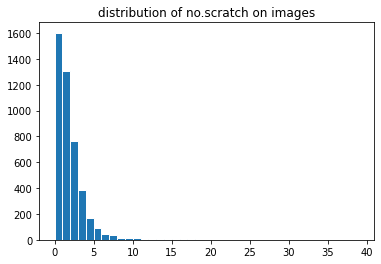

6439

In [6]:
plt.hist(damage_dist['scratch'],bins=max(damage_dist['scratch']),edgecolor='w')
plt.title('distribution of no.scratch on images')
plt.show()  
sum(damage_dist['scratch'])

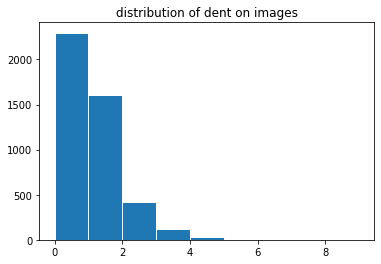

2965

In [7]:
plt.hist(damage_dist['dent'],bins=max(damage_dist['dent']),edgecolor='w')
plt.title('distribution of dent on images')
plt.show()  
sum(damage_dist['dent'])

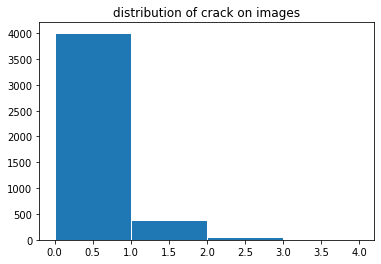

570

In [8]:
plt.hist(damage_dist['crack'],bins=max(damage_dist['crack']),edgecolor='w')
plt.title('distribution of crack on images')
plt.show()  
sum(damage_dist['crack'])

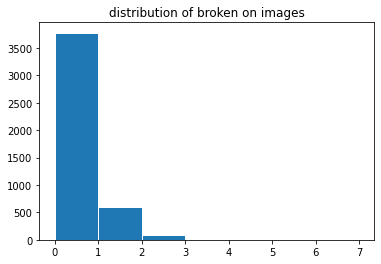

828

In [9]:
plt.hist(damage_dist['broken'],bins=max(damage_dist['broken']),edgecolor='w')
plt.title('distribution of broken on images')
plt.show()  
sum(damage_dist['broken'])

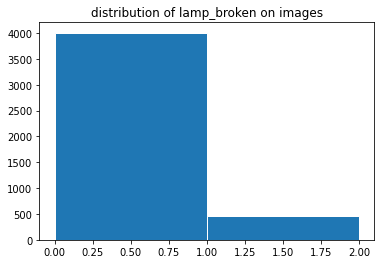

485

In [10]:
plt.hist(damage_dist['lamp_broken'],bins=max(damage_dist['lamp_broken']),edgecolor='w')
plt.title('distribution of lamp_broken on images')
plt.show()  
sum(damage_dist['lamp_broken'])

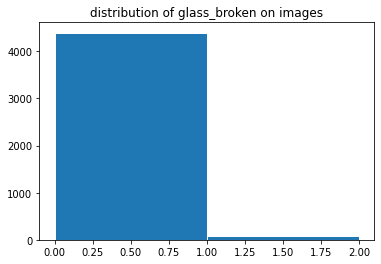

81

In [11]:
plt.hist(damage_dist['glass_broken'],bins=max(damage_dist['glass_broken']),edgecolor='w')
plt.title('distribution of glass_broken on images')
plt.show()  
sum(damage_dist['glass_broken'])

In [12]:
# plt.hist(damage_dist['hole'],bins=max(damage_dist['hole']),edgecolor='w')
# plt.title('distribution of hole on images')
# plt.show()  
sum(damage_dist['hole'])

0

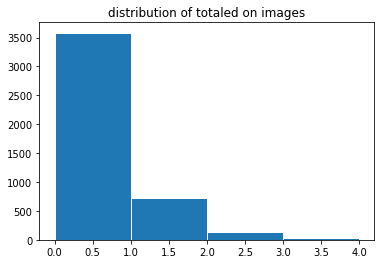

1099

In [13]:
plt.hist(damage_dist['totaled'],bins=max(damage_dist['totaled']),edgecolor='w')
plt.title('distribution of totaled on images')
plt.show()  
sum(damage_dist['totaled'])

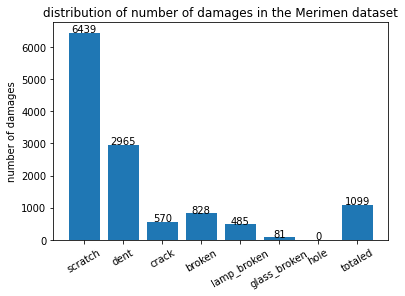

In [14]:
y = [sum(vals) for key, vals in damage_dist.items()]
plt.bar(damage_names, y)
plt.xticks(rotation=(30))
for i in range(len(damage_names)):
    plt.text(i,y[i]+10,y[i],ha = 'center')

# for i, v in enumerate(y):
#     plt.text(v + 3, i + 
#              25, str(v), color='blue', fontweight='bold')

plt.ylabel('number of damages')
plt.title('distribution of number of damages in the Merimen dataset')
plt.show()

## determine outliers

In [15]:
crack_subcat_names = ['crack', 'broken', 'lamp_broken', 'glass_broken', 'hole']
def create_img_to_damage_mapping():
    mapping_list = []
    for cls in crack_subcat_names:
        mapping_name = 'imgTo' + str(cls)
        locals()[mapping_name] = defaultdict(list)
        for ann in data['annotations']:
            if ann['category_id'] >=2 and ann['category_id'] <=6:
                
                if crack_subcat_names[ann['category_id']-2] == str(cls):
                    locals()[mapping_name][ann['image_id']].append(ann)
        mapping_list.append(locals()[mapping_name])
    return mapping_list
crack_mapping_list = create_img_to_damage_mapping()
print('number of types of crack damages', len(crack_mapping_list))

number of types of crack damages 5


In [16]:
def create_img_to_damage_mapping():
    mapping_list = []
    for cls in damage_names:
        mapping_name = 'imgTo' + str(cls)
        locals()[mapping_name] = defaultdict(list)
        for ann in data['annotations']:
            if damage_names[ann['category_id']] == str(cls):
                locals()[mapping_name][ann['image_id']].append(ann)
        mapping_list.append(locals()[mapping_name])
    return mapping_list
damage_mapping_list = create_img_to_damage_mapping()
print('number of types of damages', len(damage_mapping_list))

number of types of damages 8


In [17]:
damage_names

['scratch',
 'dent',
 'crack',
 'broken',
 'lamp_broken',
 'glass_broken',
 'hole',
 'totaled']

In [18]:
total_scratch = damage_mapping_list[damage_names.index('scratch')]
total_dent = damage_mapping_list[damage_names.index('dent')]
total_totaled = damage_mapping_list[damage_names.index('totaled')]

total_crack = damage_mapping_list[damage_names.index('crack')]
total_broken = damage_mapping_list[damage_names.index('broken')]
total_lamp_broken = damage_mapping_list[damage_names.index('lamp_broken')]
total_glass_broken = damage_mapping_list[damage_names.index('glass_broken')]
total_hole = damage_mapping_list[damage_names.index('hole')]

In [19]:
print(len(total_scratch.keys()))
print(len(total_dent.keys()))
print(len(total_totaled.keys()))


print(len(total_crack.keys()))
print(len(total_broken.keys()))
print(len(total_glass_broken.keys()))
print(len(total_lamp_broken.keys()))
print(len(total_hole.keys()))

2872
2178
891
465
698
80
469
0


In [20]:
# totaled_img_ids = total_totaled.keys()
# len(totaled_img_ids)
# totaled_case_id = []

# for img in data['images']:
#     if img['id'] in totaled_img_ids:
#         totaled_case_id.append(img['case_id'])
# totaled_case_id = set(totaled_case_id)
# total_case_id = list(caseid_to_img.keys())
# not_include_totaled_case_id = [case_id for case_id in total_case_id if case_id not in totaled_case_id]
# print(len(not_include_totaled_case_id))
# not_include_totaled_case_id
# not_totaled = {'case_ids_not_include_totaled': not_include_totaled_case_id}
# with open(path, 'w', encoding='utf-8') as json_file:
#         os.makedirs(os.path.dirname(path), exist_ok=True)
#         json.dump(data, json_file, ensure_ascii=False, indent = 4)

391


NameError: name 'path' is not defined

In [21]:
def get_img_area(img_id, data):
    for img in data['images']:
        if img['id']==img_id:
            img_area = img['height']*img['width']
            break
    return img_area

def determine_damage_outliers(damage_dict, lower_thres, upper_thres):
    damage_img_ratio = []
    large_damage = defaultdict(list)
    tiny_damage = defaultdict(list)
    for img_id, damage_anns in damage_dict.items():
        for damage_ann in damage_anns:
            damage_area = max(damage_ann['bbox'][2] * damage_ann['bbox'][3], 1e-5)
            ratio = damage_area/get_img_area(img_id, data)
            damage_img_ratio.append(ratio)
            if ratio > upper_thres:
                large_damage[img_id].append(damage_ann)
            elif ratio < lower_thres:
                tiny_damage[img_id].append(damage_ann)
    return damage_img_ratio, large_damage, tiny_damage
def flatten_list(dict_list):
    if len(dict_list.values()) == 0:
        return []
    return reduce(lambda x,y: x+y, list(dict_list.values()))

### Crack

number of tiny crack annos: 53 "
" number of large crack annos: 4
total crack annos: 570


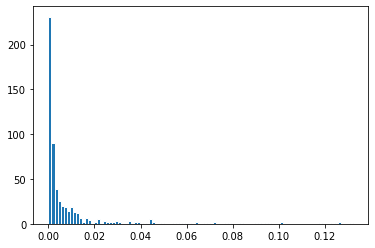

In [22]:
crack_img_ratio, large_crack, tiny_crack = determine_damage_outliers(total_crack,np.exp(-8.5), 0.2)
print('number of tiny crack annos: {} "\n" number of large crack annos: {}'.format(len(flatten_list(tiny_crack)), len(flatten_list(large_crack))))
print('total crack annos: {}'.format(len(flatten_list(total_crack))))

plt.hist([ratio for ratio in crack_img_ratio if ratio <0.2], bins=100, edgecolor='w')
plt.show()

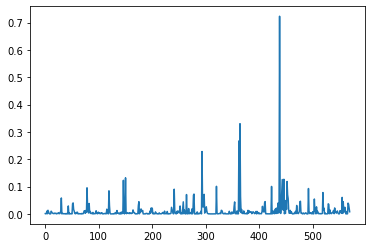

In [23]:
plt.plot(crack_img_ratio)

### Broken

number of tiny broken annos: 8 "
" number of large broken annos: 134
total broken annos: 828


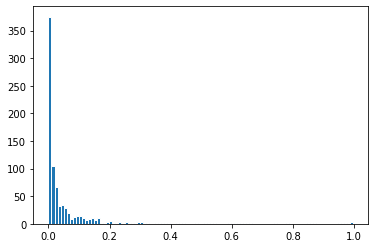

In [24]:
broken_img_ratio, large_broken, tiny_broken = determine_damage_outliers(total_broken,np.exp(-8.5), 0.1)
print('number of tiny broken annos: {} "\n" number of large broken annos: {}'.format(len(flatten_list(tiny_broken)), len(flatten_list(large_broken))))
print('total broken annos: {}'.format(len(flatten_list(total_broken))))

plt.hist([broken_img_ratio], bins=100, edgecolor='w')
plt.show()

### Lamp_broken

number of tiny lamp_broken annos: 2 "
" number of large lamp_broken annos: 99
total lamp_broken annos: 485


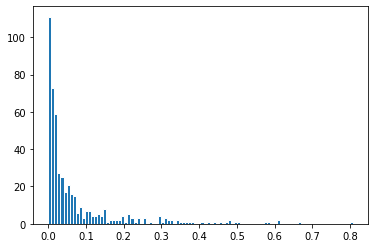

In [25]:
lamp_broken_img_ratio, large_lamp_broken, tiny_lamp_broken = determine_damage_outliers(total_lamp_broken,np.exp(-8.5), 0.1)
print('number of tiny lamp_broken annos: {} "\n" number of large lamp_broken annos: {}'.format(len(flatten_list(tiny_lamp_broken)), len(flatten_list(large_lamp_broken))))
print('total lamp_broken annos: {}'.format(len(flatten_list(total_lamp_broken))))

plt.hist(lamp_broken_img_ratio, bins=100, edgecolor='w')
plt.show()

In [26]:
# carpart_config = '/mmdetection/checkpoints/carpart_phase_2/carpart_pseudo.py'
# carpart_checkpoint = '/mmdetection/checkpoints/carpart_phase_2/epoch_24.pth'
# carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:0')
# carpart_labels = carpart_model.CLASSES
# def load_predicted_result(model, img, conf_score=0.5):
#     result = inference_detector(model, img.copy())
#     out_image,pd_boxes,pd_segs,pd_labels,pd_scores = show_result_pyplot(model,img.copy(),result,score_thr=conf_score)
#     return pd_segs,pd_labels,pd_scores,out_image
# light_labels = ['sli_side_turn_light','hli_head_light','tli_tail_light','fli_fog_light','lli_low_bumper_tail_light']
# def compute_area(seg):
#     seg = np.array(seg).reshape(-1,2).astype(np.int32)
#     area = cv2.contourArea(seg)
#     if area == 0:
#         area = 1e-5
#     return area
# def compute_iou(carpart_mask, damage_mask):
#     area1 = np.sum(carpart_mask)
#     area2 = np.sum(damage_mask)
#     overlap = np.sum(np.logical_and(carpart_mask, damage_mask))
#     iou = overlap/(area1+area2-overlap)
#     return iou
# def draw_binary_mask(seg, img_shape):
#     seg = np.array(seg).reshape(-1,2).astype(np.int32)
#     mask = np.zeros(img_shape)
#     mask = cv2.fillPoly(mask, [seg],1)
#     return mask

# iou_list=[]
# large_lamp_broken = defaultdict(list)
# tiny_lamp_broken = defaultdict(list)
# # light_infer_masks = defaultdict(list)
# for (idx, (img_id, broken_anns)) in tqdm(enumerate(total_lamp_broken.items())):
#     for img in data['images']:
#         if img['id'] == img_id:
#             img_name = img['file_name']
#             img_url = img['url']
#             img_area = img['height']*img['width']
#             case_id = img['case_id']
#             break
    
#     img_path = os.path.join('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/images/',case_id, img_name)
#     I = cv2.imread(img_path)
#     img_shape = I.shape[:2]
#     broken_segs = [draw_binary_mask(ann['segmentation'], img_shape) for ann in broken_anns]

#     pd_segs,pd_labels,pd_scores,out_image = load_predicted_result(carpart_model, I)
#     light_segs = [pd_segs[idx] for idx,pd_label in enumerate(pd_labels) if (carpart_labels[pd_label] in light_labels)]
# #     light_infer_masks[img_id] = light_segs
#     if len(light_segs) == 0:
#         continue
# #     print(len(broken_segs), len(light_segs), img_id)
 
#     for i, broken_seg in enumerate(broken_segs):
#         for light_seg in light_segs:
#             iou = compute_iou(light_seg, broken_seg)
#             iou_list.append(iou)
#             if iou>0.6:
#                 large_lamp_broken[img_id].append(broken_anns[i])
#             if iou<0.1 and np.sum(broken_seg)/img_area < 0.2:
#                 tiny_lamp_broken[img_id].append(broken_anns[i])
                
# print('number of tiny lamp_broken annos: {} "\n" number of large lamp_broken annos: {}'.format(len(flatten_list(tiny_lamp_broken)), len(flatten_list(large_lamp_broken))))
# print('total lamp_broken annos: {}'.format(len(flatten_list(total_lamp_broken))))

### Scratch

number of tiny scratch annos: 536 
number of large scratch annos: 596
total scratch annos: 6439


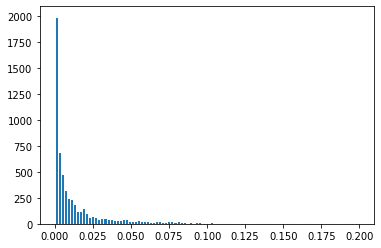

In [27]:
scratch_img_ratio, large_scratch, tiny_scratch = determine_damage_outliers(total_scratch,np.exp(-8.5), 0.1)
print('number of tiny scratch annos: {} \nnumber of large scratch annos: {}'.format(len(flatten_list(tiny_scratch)), len(flatten_list(large_scratch))))
print('total scratch annos: {}'.format(len(flatten_list(total_scratch))))

plt.hist([ratio for ratio in scratch_img_ratio if ratio<0.2], bins=100, edgecolor='w')
plt.show()

### Dent

number of tiny dent annos: 90 
number of large dent annos: 0
total dent annos: 2965


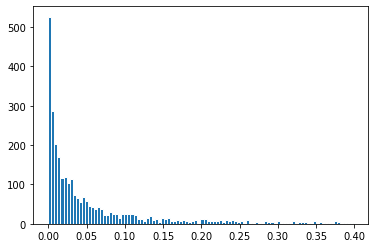

In [28]:
dent_img_ratio, large_dent, tiny_dent = determine_damage_outliers(total_dent,np.exp(-7.5), 1)
print('number of tiny dent annos: {} \nnumber of large dent annos: {}'.format(len(flatten_list(tiny_dent)), len(flatten_list(large_dent))))
print('total dent annos: {}'.format(len(flatten_list(total_dent))))

plt.hist([ratio for ratio in dent_img_ratio if ratio<0.4], bins=100, edgecolor='w')
plt.show()

### Totaled

number of tiny totaled annos: 0 
number of large totaled annos: 0
total totaled annos: 1099


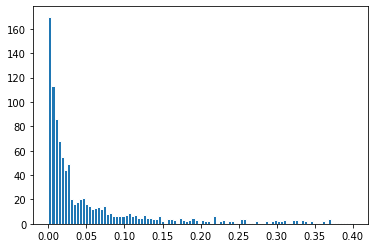

In [29]:
totaled_img_ratio, large_totaled, tiny_totaled = determine_damage_outliers(total_totaled,np.exp(-10), 1)
print('number of tiny totaled annos: {} \nnumber of large totaled annos: {}'.format(len(flatten_list(tiny_totaled)), len(flatten_list(large_totaled))))
print('total totaled annos: {}'.format(len(flatten_list(total_totaled))))

plt.hist([ratio for ratio in totaled_img_ratio if ratio<0.4], bins=100, edgecolor='w')
plt.show()

### remove outliers and relabel

In [102]:
#clean data --> new_data
def double_check(data):
    img_ids = [img['id'] for img in data['images']]
    img_ids_in_annos = set([ann['image_id'] for ann in data['annotations']])
    differential_quant = len(img_ids) - len(img_ids_in_annos)
    if (differential_quant <= 0):
        print("check 'double_check' function again")
    else:
        print('have positive differential quantity')
        new_images = []
        for img in data['images']:
            if img['id'] in img_ids_in_annos:
                new_images.append(img)
        data['images'] = new_images
    return data
total_removed_anns = list(tiny_crack.values()) + list(tiny_dent.values()) + list(tiny_broken.values()) + list(tiny_scratch.values())
total_removed_anns = reduce(lambda x,y: x+y, total_removed_anns)

new_data = copy.deepcopy(data)
new_data['annotations'] = [ann for ann in new_data['annotations'] if ann not in total_removed_anns]

double_check(new_data)

scratch_anns = [ann for ann in new_data['annotations'] if ann['category_id']==0]
dent_anns = [ann for ann in new_data['annotations'] if ann['category_id']==1]
crack_broken_anns = [ann for ann in new_data['annotations'] if ann['category_id']==2 or ann['category_id']==3]
# broken_anns = [ann for ann in new_data['annotations'] if ann['category_id']==3]
totaled_anns = [ann for ann in new_data['annotations'] if ann['category_id']==7]
# crack_broken_anns = crack_anns + broken_anns
def ann_img_mapping(ann_list,raw_data):
    img_ids = set([ann['image_id'] for ann in ann_list])
    img_list=[img for img in raw_data['images'] if img['id'] in img_ids]
    img_names = defaultdict(list)
    for img in img_list:
        img_names[img['case_id']].append(img['file_name'])

    for img in img_list:
        img['file_name'] = str(img['case_id']).replace(' ','') + '_' + img['file_name']
        
    return img_list, img_names

scratch_imgs, scratch_img_names = ann_img_mapping(scratch_anns, copy.deepcopy(new_data))
dent_imgs, dent_img_names= ann_img_mapping(dent_anns, copy.deepcopy(new_data))
crack_broken_imgs, crack_broken_img_names = ann_img_mapping(crack_broken_anns, copy.deepcopy(new_data))
totaled_imgs, totaled_img_names = ann_img_mapping(totaled_anns,copy.deepcopy(new_data))

# print('before scratch_imgs ',scratch_imgs)
# scratch_imgs=rename_img_filename(scratch_imgs)
# dent_imgs=rename_img_filename(dent_imgs)
# crack_broken_imgs=rename_img_filename(crack_broken_imgs)
# totaled_imgs=rename_img_filename(totaled_imgs)

scratch_cats = [{'supercategory': 'Carparts', 'id': 0, 'name': 'scratch'}]
dent_cats = [{'supercategory': 'Carparts', 'id': 0, 'name': 'dent'}]
crack_broken_cats = [{'supercategory': 'Carparts', 'id': 0, 'name': 'crack'}, {'supercategory': 'Carparts', 'id': 1, 'name': 'broken'}]
totaled_cats = [{'supercategory': 'Carparts', 'id': 0, 'name': 'totaled'}]


def copy_and_customize_data(orgin_data, des_anns, des_imgs,des_cats):
    new_data = copy.deepcopy(orgin_data)
    new_data['annotations'] = des_anns
    new_data['images'] = des_imgs
    new_data['categories'] = des_cats
    for ann in new_data['annotations']:
        if ann['category_id'] not in [2,3]:
            ann['category_id'] = 0
        elif ann['category_id'] == 2:
            ann['category_id'] = 0
        elif ann['category_id'] == 3:
            ann['category_id'] = 1
    return new_data

def json_dumping(path, data):
    with open(path, 'w', encoding='utf-8') as json_file:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        json.dump(data, json_file, ensure_ascii=False, indent = 4)

have positive differential quantity


In [103]:
scratch_data = copy_and_customize_data(new_data, scratch_anns, scratch_imgs, scratch_cats)
json_dumping('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/scratch/annotations/test.json', scratch_data)

In [104]:
dent_data = copy_and_customize_data(new_data, dent_anns, dent_imgs, dent_cats)
json_dumping('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/dent/annotations/test.json', dent_data)

In [105]:
crack_broken_data = copy_and_customize_data(new_data, crack_broken_anns, crack_broken_imgs, crack_broken_cats)
json_dumping('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/annotations/test.json', crack_broken_data)

In [106]:
totaled_data = copy_and_customize_data(new_data, totaled_anns, totaled_imgs, totaled_cats)
json_dumping('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/totaled/annotations/test.json', totaled_data)

In [59]:
def move_file(origin_dir, dest_root_dir, file_names):
    for folder_name, f_names in file_names.items():
        current_folder_path = os.path.join(origin_dir, folder_name)
        files_list = [f for f in listdir(current_folder_path) if isfile(join(current_folder_path, f))]
        
        for file_name in f_names:
            if file_name in files_list:
                new_file_name = str(folder_name).replace(' ','')+'_'+file_name
                src = os.path.join(current_folder_path, file_name)
                
                dest_dir = os.path.join(dest_root_dir,new_file_name)
#                 if os.path.isdir(dest_dir) == False:
#                     os.mkdir(dest_dir)
#                 dest_dir = os.path.join(dest_dir, file_name)
        
                des = shutil.copy(src, dest_dir)
#                 des = shutil.copy(src, dest_root_dir)
        
origin_imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/images'

scratch_imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/scratch/images/'
dent_imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/dent/images/'
crack_broken_imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/images/'
totaled_imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/totaled/images/'

In [65]:
move_file(origin_imgs_path, scratch_imgs_path, scratch_img_names)

In [66]:
move_file(origin_imgs_path, dent_imgs_path, dent_img_names)

In [67]:
move_file(origin_imgs_path, crack_broken_imgs_path, crack_broken_img_names)

In [68]:
move_file(origin_imgs_path, totaled_imgs_path, totaled_img_names)

In [ ]:
dent_case_names

In [63]:
shutil.rmtree('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/images/')

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/images/50422'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

In [107]:
crack_broken_data = json.load(open('/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/annotations/test.json'))
img_file_names = []
ids = set([ann['category_id'] for ann in crack_broken_data['annotations']])
for img in crack_broken_data['images']:
    img_file_names.append(img['file_name'])
#     print(img['case_id'],'---',img['file_name'])
imgs_path = '/mmdetection/data/coco_datasets/datasets/generalide/17_05_2022/annotations/annotations_for_each_damage/crack-broken/images'
list_imgs = [f for f in listdir(imgs_path) if isfile(join(imgs_path,f))]
ids

{0, 1}

In [90]:
print(len(img_file_names))
print(len(list_imgs))

991
991


In [73]:
error = 0
for i in img_file_names:
    if i not in list_imgs:
        print(i)
        error += 1
print(error)

0


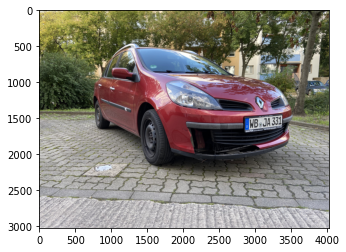

In [84]:
name = '8746821_front_right_view_18.jpeg'
I = cv2.imread(os.path.join(imgs_path,name))

plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
               